In [8]:
using Gen, Plots, Images, Colors, Serialization

In [9]:
# Global vars
IMG_SIZE = 50;

## Rendering of a scene

In [54]:
# Drawing utilities

# colors
BLANK = [1.0, 1.0, 1.0]
color_map = Dict("red" => [1.0, 0.0, 0.0], "yellow" => [1.0, 1.0, 0.0], "green" => [0.0, 1.0, 0.0])

# shapes
function draw_square!(img, center, size, color)
    overlap = false
    x, y = center
    half_size = size ÷ 2
    for dx in -half_size:half_size, dy in -half_size:half_size
        nx, ny = x + dx, y + dy
        if 1 <= nx <= IMG_SIZE && 1 <= ny <= IMG_SIZE
            if img[ny, nx] != BLANK
                overlap = true
            end
            img[ny, nx] = color
        end
    end
    return overlap
end

# Function to draw a circle
function draw_circle!(img, center, radius, color)
    overlap = false
    x, y = center
    for dx in -radius:radius, dy in -radius:radius
        if dx^2 + dy^2 <= radius^2
            nx, ny = x + dx, y + dy
            if 1 <= nx <= IMG_SIZE && 1 <= ny <= IMG_SIZE
                if img[ny, nx] != BLANK
                    overlap = true
                end
                img[ny, nx] = color
            end
        end
    end
    return overlap
end

shape_map = Dict("square" => draw_square!, "circle" => draw_circle!, "star" => draw_square!)

Dict{String, Function} with 3 entries:
  "circle" => draw_circle!
  "star"   => draw_square!
  "square" => draw_square!

In [169]:
function to_display_img(img_matrix)
    return [RGB(img_matrix[i, j]...) for i in 1:IMG_SIZE, j in 1:IMG_SIZE]
end

function render(objects, show_img=false, return_does_overlap=false)
    overlap = false
    img = fill([1.0,1.0,1.0], IMG_SIZE, IMG_SIZE)
    for (shape, color, center) in objects
        if shape_map[shape](img, center, 10, color_map[color])
            overlap = true
        end
    end
    if show_img
        display(to_display_img(img))
    end
    if return_does_overlap
        return img, overlap
    end
    return img
end

function render_trace(trace, show_img=false)
    objects = get_retval(trace)
    return render(objects, show_img)
    end

render_trace (generic function with 2 methods)

## Generative model for a scene

In [279]:
# See if should be static compiled for inference efficiency
@gen function scene()
    # Defining how many objects are in the scene
    n_objects ~ poisson(2)
    n_objects += 1 # Making sure at least 1 object

    shape_universe = ["square", "circle"]
    color_universe = ["red", "yellow", "green"]

    # Should probably make this a passed in param
    
    objects = []
    for i = 1:n_objects

        shape_idx = {(:shape, i)} ~ uniform_discrete(1,2)
        shape = shape_universe[shape_idx]

        color_idx = {(:color, i)} ~ uniform_discrete(1,3)
        color = color_universe[color_idx]

        x = {(:x, i)} ~ uniform_discrete(1, IMG_SIZE)
        y = {(:y, i)} ~ uniform_discrete(1, IMG_SIZE)
        
        push!(objects, (shape, color, (x, y)))
    end
    
    return objects
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##scene#1312", Bool[], false)

In [13]:
# Generative for scoring
@gen function render_model()
    latents ~ scene()
    x = render(latents)
    obs ~ obs_mixture(x)
    return nothing
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##render_model#293", Bool[], false)

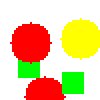

In [15]:
# Example usage
render_trace(Gen.simulate(scene, ()), true);

## Scoring sampled scenes

In [16]:
# Image observation distribution
struct ObservationMixture <: Distribution{Matrix{Vector{Float64}}} end

function Gen.random(::ObservationMixture, X::Matrix{Vector{Float64}})
    # Throw an error since just a scoring fn
    return X
end

function Gen.logpdf(::ObservationMixture,
        Y::Matrix{Vector{Float64}},
        X::Matrix{Vector{Float64}})

    blank = fill([1.0,1.0,1.0], size(X))
    input_non_background_mask = .!(X .== blank)
    obs_non_background_mask = .!(Y .== blank)

    obs_non_background = Y[input_non_background_mask]
    input_non_background = X[input_non_background_mask]

    # Use IOU (intersection over union) as score
    intersection = sum(obs_non_background .== input_non_background)
    union = sum(obs_non_background_mask .| input_non_background_mask)
    return log(intersection) - log(union)
end

function obs_score(obs, gen)
    return logpdf(ObservationMixture(), obs, gen)
end

(o::ObservationMixture)(arg) = Gen.random(o, arg)

In [17]:
obs_mixture = ObservationMixture()
foo = render(scene())
foo2 = render(scene())
_ = obs_mixture(foo)
print("Sanity checking score fn: ", exp(logpdf(obs_mixture, foo,  foo)))

Sanity checking score fn: 1.0

## Inference procedure

In [18]:
# Inference display utils
function render_samples(traces, log_weights)
    normalized_log_weights = log_weights .- logsumexp(log_weights)
    sample_weights = exp.(normalized_log_weights)
    cum_sampled_scene = render(traces[1][:latents]) * sample_weights[1]
    for i=2:length(traces)
        sampled_scene = render(traces[i][:latents]) * sample_weights[i]
        cum_sampled_scene += sampled_scene
    end
    return cum_sampled_scene
end

render_samples (generic function with 1 method)

In [19]:
# MAP estimate of paramters (ML since uniform)
function get_ml_trace(traces, log_weights)
    log_weights = log_weights .- logsumexp(log_weights)
    weight_sort_perm = sortperm(log_weights, rev=true)
    sorted_weights = log_weights[weight_sort_perm]
    sorted_traces = traces[weight_sort_perm]
    return sorted_traces[1], sorted_weights[1]
end

get_ml_trace (generic function with 1 method)

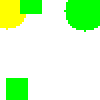

In [364]:
obs_trace, _ = generate(scene, (), Gen.choicemap())
obs = render_trace(obs_trace);
to_display_img(obs)

In [365]:
# Example inference procedure
function do_importance_sample(model, constraints, num_iter)
    (traces, weights, _) = Gen.importance_sampling(model, (), constraints, num_iter);
    return traces, weights
end;

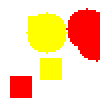

In [386]:
constraints = Gen.choicemap()
constraints[:n_objects] = 5
t, _ = generate(scene, (), constraints)
to_display_img(render_trace(t))

In [366]:
constraints = Gen.choicemap()
constraints[:obs] = obs
traces, weights = do_importance_sample(render_model, constraints, 100000);

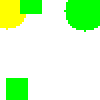

In [367]:
to_display_img(obs)

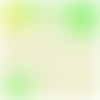

In [368]:
to_display_img(render_samples(traces, weights))

P(obs|latent*) 0.6151260504201677


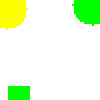

In [369]:
best_trace, best_weight = get_ml_trace(traces, weights)
println("P(obs|latent*) ", exp(obs_score(obs, render(best_trace[:latents]))))
to_display_img(render_samples([best_trace,], [best_weight,]))

In [371]:
get_score(best_trace)

-30.64019733183736

### Experimenting w/ constraints

In [31]:
constraints = Gen.choicemap()
constraints[:obs] = obs
constraints[:latents => :n_objects] = obs_trace[:n_objects]
for i in 1:obs_trace[:n_objects]+1
    constraints[:latents => (:shape, i)] = obs_trace[(:shape, i)]
    constraints[:latents => (:color, i)] = obs_trace[(:color, i)]
end

traces, weights = do_importance_sample(render_model, constraints, 100000);

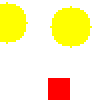

In [32]:
to_display_img(obs)

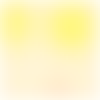

In [33]:
to_display_img(render_samples(traces, weights))

P(obs|latent*) 0.7741514360313321


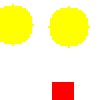

In [34]:
best_trace, best_weight = get_ml_trace(traces, weights)
println("P(obs|latent*) ", exp(obs_score(obs, render(best_trace[:latents]))))
to_display_img(render_samples([best_trace,], [best_weight,]))

## MCMC

In [35]:
function get_unconstrained_vars(vars, constraints)
    valid_vars = []
    for var in vars
        if !Gen.has_value(constraints, var)
            push!(valid_vars, var)
        end
    end
    return valid_vars
end

get_unconstrained_vars (generic function with 1 method)

In [36]:
# Just to get started, doing unconditional resimulation
function block_resimulation_update(tr, constraints)
    # Block 1: Update the number of objects
    n_object_valid = get_unconstrained_vars((:latents => :n_objects, ), constraints)
    (tr, _) = mh(tr, select(n_object_valid...))
    
    # Block 2: Update categorical (i.e. shape & color)
    n = length(tr[:latents])
    for i=1:n
        shape_color_valid = get_unconstrained_vars(
            (
                :latents => (:shape, i),
                :latents => (:color, i),),
            constraints
        )
        (tr, _) = mh(tr, select(shape_color_valid...))
    end

    # Block to change the position
    n = length(tr[:latents])
    for i=1:n
        (tr, _) = mh(tr, select(
                :latents => (:x, i),
                :latents => (:y, i),))
    end
    
    # Return the updated trace
    tr
end;


In [37]:
# Just to get started, doing unconditional resimulation
MAX_DRIFT = 2
@gen function position_proposal(current_trace, i)
    cur_x = current_trace[:latents => (:x, i)]
    cur_y = current_trace[:latents => (:y, i)]
    
    new_x_min = max(cur_x-MAX_DRIFT, 1)
    new_x_max = min(cur_x+MAX_DRIFT, IMG_SIZE)
    new_y_min = max(cur_y-MAX_DRIFT, 1)
    new_y_max = min(cur_y+MAX_DRIFT, IMG_SIZE)
    
    x = {:latents => (:x, i)} ~ uniform_discrete(new_x_min, new_x_max)
    y = {:latents => (:y, i)} ~ uniform_discrete(new_y_min, new_y_max)
end;

function block_drift_update(tr, constraints)
    # Block 1: Update the number of objects
    n_object_valid = get_unconstrained_vars((:latents => :n_objects, ), constraints)
    (tr, _) = mh(tr, select(n_object_valid...))
    
    # Block 2: Update categorical (i.e. shape & color)
    n = length(tr[:latents])
    for i=1:n
        shape_color_valid = get_unconstrained_vars(
            (
                :latents => (:shape, i),
                :latents => (:color, i),),
            constraints
        )
        (tr, _) = mh(tr, select(shape_color_valid...))
    end

    # Update block positions
    n = length(tr[:latents])
    for i=1:n
        (tr, _) = mh(tr, position_proposal, (i,))
    end
    
    # Return the updated trace
    tr
end;


Obs: 


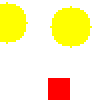

MCMC: 


[ Info: Saved animation to /Users/zackankner/Desktop/ai/PerceptToWorldModel/ppl/tmp.gif


Plots.AnimatedGif("/Users/zackankner/Desktop/ai/PerceptToWorldModel/ppl/tmp.gif")
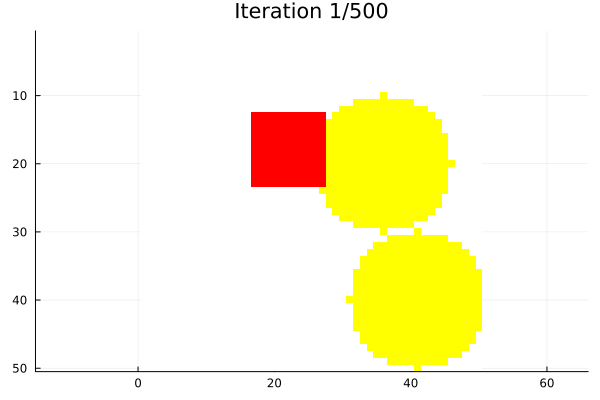

In [38]:
# MCMC visualization util
constraints = Gen.choicemap()
constraints[:obs] = obs
constraints[:latents => :n_objects] = obs_trace[:n_objects]
for i in 1:obs_trace[:n_objects]+1
    constraints[:latents => (:shape, i)] = obs_trace[(:shape, i)]
    constraints[:latents => (:color, i)] = obs_trace[(:color, i)]
end

println("Obs: ")
display(to_display_img(obs))
println("MCMC: ")
t, = generate(render_model, (), constraints)
num_iter = 500
viz = Plots.@animate for i in 1:num_iter
    global t
    t = block_resimulation_update(t, constraints)
    plot(to_display_img(render(t[:latents])), title="Iteration $i/$num_iter")
end;
gif(viz)

Obs: 


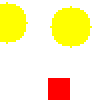

MCMC: 


[ Info: Saved animation to /Users/zackankner/Desktop/ai/PerceptToWorldModel/ppl/tmp.gif


Plots.AnimatedGif("/Users/zackankner/Desktop/ai/PerceptToWorldModel/ppl/tmp.gif")
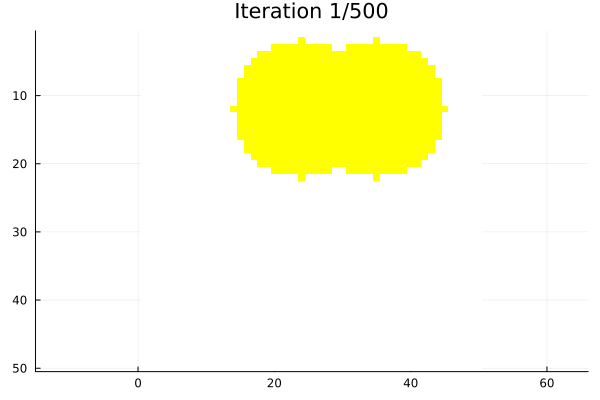

In [39]:
# MCMC visualization util
constraints = Gen.choicemap()
constraints[:obs] = obs
constraints[:latents => :n_objects] = obs_trace[:n_objects]
for i in 1:obs_trace[:n_objects]+1
    constraints[:latents => (:shape, i)] = obs_trace[(:shape, i)]
    constraints[:latents => (:color, i)] = obs_trace[(:color, i)]
end

println("Obs: ")
display(to_display_img(obs))
println("MCMC: ")
t, = generate(render_model, (), constraints)

num_iter = 500
viz = Plots.@animate for i in 1:num_iter
    global t
    t = block_drift_update(t, constraints)
    plot(to_display_img(render(t[:latents])), title="Iteration $i/$num_iter")
end;
gif(viz)

## SMC

In [44]:
function particle_filter(model, num_particles::Int, constraints, num_steps::Int, num_samples::Int)

    # Initialize particles
    state = Gen.initialize_particle_filter(model, (), constraints, num_particles)
    
    # steps
    for t=1:num_steps
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        # obs = Gen.choicemap(((:z, t), zs[t+1]))
        Gen.particle_filter_step!(state, (), (UnknownChange(),), Gen.choicemap())
    end
    
    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;

In [45]:
constraints = Gen.choicemap()
constraints[:obs] = obs

constraints[:latents => :n_objects] = obs_trace[:n_objects]
for i in 1:obs_trace[:n_objects]+1
    constraints[:latents => (:shape, i)] = obs_trace[(:shape, i)]
    constraints[:latents => (:color, i)] = obs_trace[(:color, i)]
end

traces = particle_filter(render_model, 100, constraints, 1000, 10);

LoadError: DomainError with [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]:
Categorical: vector p is not a probability vector

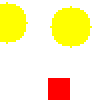

In [42]:
to_display_img(obs)

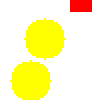

In [43]:
to_display_img(render(traces[9][:latents]))

# Paper results methods

## Storing fixed observations

In [47]:
NUM_OBSERVATIONS = 5;

#### We first build observations whose shapes don't overlap

In [170]:
@gen function render_no_overlaps()
    overlap = true
    x = nothing
    while overlap
        latents ~ scene()
        x, overlap = render(latents, false, true)
    end
    return x
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##render_no_overlaps#1310", Bool[], false)

Observation 1


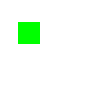

Observation 2


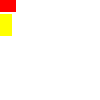

Observation 3


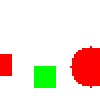

Observation 4


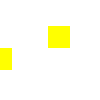

Observation 5


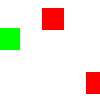

In [262]:
# Commented out because only want to run once

# for obs_idx in 1:NUM_OBSERVATIONS
#     println("Observation $obs_idx")
#     obs = render_no_overlaps()
#     open("observations/no-overlap/obs-$obs_idx.bin", "w") do file
#         serialize(file, obs)
#     end
#     display(to_display_img(obs))
# end

#### We next build observations with overlaps to induce structural uncertainty

In [272]:
@gen function render_with_overlaps()
    overlap = false
    x = nothing
    while !overlap
        latents ~ scene()
        x, overlap = render(latents, false, true)
    end
    return x
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##render_with_overlaps#1311", Bool[], false)

Observation 1


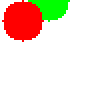

Observation 2


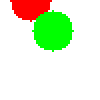

Observation 3


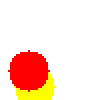

Observation 4


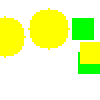

Observation 5


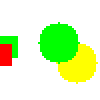

In [351]:
# Commented out because only want to run once

# for obs_idx in 1:NUM_OBSERVATIONS
#     println("Observation $obs_idx")
#     obs = render_with_overlaps()
#     open("observations/with-overlap/obs-$obs_idx.bin", "w") do file
#         serialize(file, obs)
#     end
#     display(to_display_img(obs))
# end

#### Utility to load saved observations

In [357]:
function load_observations(base_path)
    observations = []
    for obs_idx in 1:NUM_OBSERVATIONS
        open("$base_path/obs-$obs_idx.bin", "r") do file
            push!(observations, deserialize(file))
        end
    end
    return observations
end

load_observations (generic function with 1 method)

In [362]:
no_overlap_observations = load_observations("observations/no-overlap");
with_overlap_observations = load_observations("observations/with-overlap");

## Prompts

#### Prompt for VLM

List all objects in the image. For each object state the color and shape of the object. The possible shapes are "square" and "circle". The possible colors are "green", "red", and "yellow". Return nothing else but this list. Do not miss a single object even if they are overlapping.


#### Prompt for code model

Convert descriptions of a scene into constraints:

Description:
Yellow circle
Yellow circle
Green square
Green square

Constraints:
constraints[:latents => :n_objects] = 4

constraints[:latents => (:color, 1)] = yellow
constraints[:latents => (:shape, 1)] = circle

constraints[:latents => (:color, 2)] = yellow
constraints[:latents => (:shape, 2)] = circle

constraints[:latents => (:color, 3)] = green
constraints[:latents => (:shape, 3)] = square

constraints[:latents => (:color, 1)] = green
constraints[:latents => (:shape, 1)] = square

Description:

## Inference procedures
We now define a common interface for all inference procedures so we can easily experiment with their performance.

Each procedure must take in:
* a max number of inference steps (samples for importance, transitions for MCMC, total particles for SMC)
* evaluate the MAP estimate at each order of magnitude in steps

### Importance Sampling

In [ ]:
# Example inference procedure
function importance_sample_inference(model, constraints, max_iter)
    if !isinteger(log10(max_iter))
        throw(ArgumentError("The max iter $max_iter is not a power of 10"))
    end
    (traces, weights, _) = Gen.importance_sampling(model, (), constraints, max_iter);
    return traces, weights
end;